## This notebook check the hexapod state transitions and move/offset commands
## It also checks the LUT against the input polynomials, before and after a slew

This notebook works with both hexapods.

To switch between the hexapods, change the cell below.

In [1]:
hexIdx = 1 #camera hexapod
#hexIdx = 2 #M2 hexapod

In [2]:
from lsst.ts import salobj
import asyncio
import os
import yaml

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd

from lsst.ts.idl.enums import ATPtg
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

In [3]:
import os
print(os.environ["OSPL_URI"])
if os.environ.get("LSST_DDS_ALIGNER", "false") != "false":
    print("LSST_DDS_ALIGNER is mis-configured")

file:///home/hdrass/WORK/ts_ddsconfig/config/ospl-sp.xml


In [5]:
start_time = datetime.now()
script = salobj.Controller("Script", index=1)

#wait 10 second may help with DDS problems; closing all other kernels may help too
#This is to avoid a race condition between when the domain register the master and the readers are registered.
await asyncio.sleep(25) 

time to start is 0:00:36.563116 [s]


In [27]:
ptg = salobj.Remote(script.domain, "MTPtg")

In [ ]:
hex = salobj.Remote(script.domain, "MTHexapod", index=hexIdx) #1 for camera hexapod and 2 for m2 hexapod

In [29]:
mount = salobj.Remote(script.domain, "MTMount")

In [ ]:
#Start a controller instead of the Mount simulator
#mount = salobj.Controller(name="MTMount", index=0)

In [ ]:
rot = salobj.Remote(script.domain, "MTRotator")
print(f'time to start is {datetime.now() - start_time} [s]')

In [10]:
await asyncio.gather(ptg.start_task,
                     mount.start_task,
                     script.start_task, #                     
                     rot.start_task,
                     hex.start_task)

[None, None, None, None, None]

In [11]:
#As long as you get something its OK. we dont' care about h.heartbeat
await hex.evt_heartbeat.next(flush=True, timeout=5)

In [28]:
await ptg.evt_heartbeat.next(flush=True, timeout=5)

TimeoutError: 

In [12]:
#Check some configurations
hexConfig = await hex.evt_configuration.aget(timeout=10.)
print("pivot at (%.0f, %.0f, %.0f) microns "%(hexConfig.pivotX, hexConfig.pivotY, hexConfig.pivotZ))
print("maxXY = ", hexConfig.maxXY, "microns, maxZ= ", hexConfig.maxZ, " microns")
print("maxUV = ", hexConfig.maxUV, "deg, maxW= ", hexConfig.maxW, " deg")

pivot at (0, 0, -2758400) microns 
maxXY =  11400.0 microns, maxZ=  13100.0  microns
maxUV =  0.36 deg, maxW=  0.1  deg


### test state transition. If hex is already enabled, disable then enable it.

In [14]:
state = await hex.evt_summaryState.aget(timeout=5)
print('staring with: hex state', salobj.State(state.summaryState), pd.to_datetime(state.private_sndStamp, unit='s'))
if state.summaryState == 2:
    await salobj.set_summary_state(hex, salobj.State.DISABLED) #disable hex
await salobj.set_summary_state(remote=hex, state=salobj.State.STANDBY)
await salobj.set_summary_state(hex, salobj.State.ENABLED, settingsToApply="default") #enable hex

staring with: hex state State.OFFLINE 2021-03-23 19:11:29.875746816


RuntimeError: Error on cmd=cmd_enterControl, initial_state=4: msg='Command failed', ackcmd=(ackcmd private_seqNum=811572006, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: Controller is not connected')

In [15]:
from lsst_efd_client import EfdClient

client = EfdClient('summit_efd')
csc_index = 1
end = Time(datetime.now(), scale='tai')
start = end - timedelta(hours=1)
while True: #may need to wait a few seconds before event shows up in EFD
    dfe = await client.select_time_series('lsst.sal.MTHexapod.logevent_summaryState', '*', start, end, csc_index)
    if len(dfe)>0:
        break
#to check messages in Kafka, go to https://lsst-kafka-0-nts-efd.ncsa.illinois.edu/
#we cannot get time series data from DDS. We have to query the EFD

In [16]:
dfe

,MTHexapodID,priority,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,summaryState
2021-03-23 18:28:09.193000+00:00,1,0,0,MTHexapod:1,1.616524e+09,5858,1.616524e+09,959a0a03,35,1.616524e+09,1
2021-03-23 18:28:13.467000+00:00,1,0,0,MTHexapod:1,1.616524e+09,5858,1.616524e+09,959a0a03,36,1.616524e+09,5
2021-03-23 18:28:18.952000+00:00,1,0,0,MTHexapod:1,1.616524e+09,5858,1.616524e+09,959a0a03,37,1.616524e+09,4
2021-03-23 18:38:02.755000+00:00,1,0,0,MTHexapod:1,1.616525e+09,5858,1.616525e+09,959a0a03,38,1.616525e+09,5
2021-03-23 18:38:04.197000+00:00,1,0,0,MTHexapod:1,1.616525e+09,5858,1.616525e+09,959a0a03,39,1.616525e+09,1
2021-03-23 18:38:42.181000+00:00,1,0,0,MTHexapod:1,1.616525e+09,5858,1.616525e+09,959a0a03,40,1.616525e+09,2
2021-03-23 19:02:05.257000+00:00,1,0,0,MTHexapod:1,1.616526e+09,5858,1.616526e+09,959a0a03,41,1.616526e+09,1
2021-03-23 19:02:05.307000+00:00,1,0,0,MTHexapod:1,1.616526e+09,5858,1.616526e+09,959a0a03,42,1.616526e+09,5
2021-03-23 19:11:29.875000+00:00,1,0,0,MTHexapod:1,1.616527e+09,5858,1.616527e+09,959a0a03,43,1.616527e+09,4


### check the behavior when LUT is disabled.

In [17]:
lutMode = await hex.evt_compensationMode.aget(timeout=10)
print("compsensation mode enabled?",lutMode.enabled)

compsensation mode enabled? False


In [18]:
async def printPosition(hex):
    pos = await hex.tel_application.next(flush=True, timeout=10.)
    print("Current Hexapod position")
    print(" ".join(f"{p:10.2f}" for p in pos.position))
await printPosition(hex)

TimeoutError: 

If you want to observe the motions in chronograf, consider using "AND MTHexapodID={hexId}" to filter out telemetry from the other hexapod

In [ ]:
hex.evt_inPosition.flush()
for step in range(5,-1,-1):
    #await hex.cmd_move.set_start(x=0,y=0,z=100*step, u=0,v=0,w=0,sync=True)
    #Steps made smaller make sure to not go into fault
    await hex.cmd_move.set_start(x=0,y=0,z=50*step, u=0,v=0,w=0,sync=True)

    while True:
        state = await hex.evt_inPosition.next(flush=False, timeout=10)
        print("hex in position?",state.inPosition, pd.to_datetime(state.private_sndStamp, unit='s'))
        if state.inPosition:
            break
    await printPosition(hex)

In [ ]:
hex.evt_inPosition.flush()
for step in [1,2,3,-3,-2,-1]:
    #according to XML, units are micron and degree
    #await hex.cmd_offset.set_start(x=0,y=0,z=100*step, u=0,v=0,w=0,sync=True)
    #Steps made smaller make sure to not go into fault
    await hex.cmd_move.set_start(x=0,y=0,z=50*step, u=0,v=0,w=0,sync=True)
    while True:
        state = await hex.evt_inPosition.next(flush=False, timeout=10)
        print("hex in position?",state.inPosition, pd.to_datetime(state.private_sndStamp, unit='s'))
        if state.inPosition:
            break
    await printPosition(hex)
    end = Time(datetime.now(), scale='tai')

In [19]:
start = end - timedelta(seconds=30)
df = await client.select_time_series('lsst.sal.MTHexapod.application', '*', start, end, csc_index)
idx=df.MTHexapodID==1
df = df[idx]

AttributeError: 'DataFrame' object has no attribute 'MTHexapodID'

AttributeError: 'DataFrame' object has no attribute 'position2'

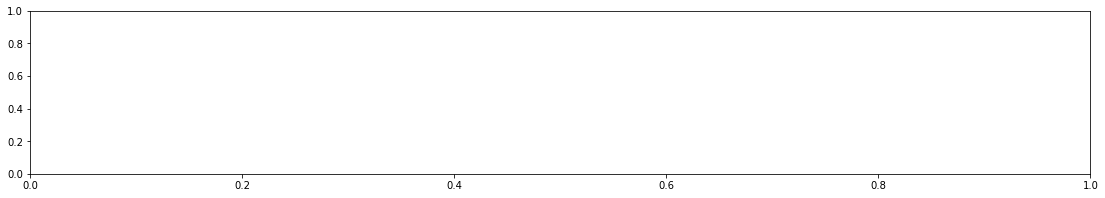

In [20]:
fig, ax = plt.subplots(figsize=(19,3))
plt.plot(df.position2)
plt.grid()

### When the LUT is enabled

In [21]:
await hex.cmd_setCompensationMode.set_start(enable=1, timeout=10)
lutMode = await hex.evt_compensationMode.aget(timeout=10)
print("compsensation mode enabled?",lutMode.enabled)

AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=1477294520, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: Not allowed in state=<State.OFFLINE: 4>')

In [ ]:
await printPosition(hex)

In [13]:
async def printUncompensatedAndCompensated(hex):
    posU = await hex.evt_uncompensatedPosition.aget(timeout=10.)
    print('Uncompensated position')
    print(" ".join(f"{p:10.2f}" for p in [getattr(posU, i) for i in 'xyzuvw']))
    posC = await hex.evt_compensatedPosition.aget(timeout=10.)
    print('Compensated position')
    print(" ".join(f"{p:10.2f}" for p in [getattr(posC, i) for i in 'xyzuvw']))

await printUncompensatedAndCompensated(hex)

TimeoutError: 

The inputs to the LUT are currently -
* elevation (from mount telemetry) 
* temperature (mount truss? not implemented yet)
* azimuth (not implemented)
* rotator angle (not implemented)

In [30]:
#Mount needs to be prepared
await salobj.set_summary_state(mount, salobj.State.ENABLED)

RuntimeError: Error on cmd=cmd_enable, initial_state=1: msg='Command failed', ackcmd=(ackcmd private_seqNum=548964986, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: There are active interlocks: Camera Cable Wrap Safety<PARSED_NL><PARSED_NL>Not accepted command: 1001')

In [ ]:
mountAngle = await mount.tel_elevation.aget(timeout=10.)
print("mount elevation angle", mountAngle.angleActual)
elev = mountAngle.angleActual

In [ ]:
#To set the elevation for a controller
mount.evt_target.set_put(elevation=45)

In [ ]:
end = Time(datetime.now())
start = end - timedelta(hours=3)
logeventTarget = await client.select_time_series('lsst.sal.MTMount.logevent_target', '*', start.tai, end.tai)

In [ ]:
#get the elevation into a variable
elev=logeventTarget.elevation
print("Mount controller elevation from the EFD:")
elev

In [6]:
elev=45.0

In [7]:
LUTfile = '%s/notebooks/ts_config_mttcs/MTHexapod/v1/default.yaml'%(os.environ["HOME"])
with open(LUTfile, 'r') as stream:
    aa = yaml.safe_load(stream)
if hex.salinfo.index == 1:
    elevCoeff = aa['camera_config']['elevation_coeffs']
    tCoeff = aa['camera_config']['temperature_coeffs']
elif hex.salinfo.index == 2:
    elevCoeff = aa['m2_config']['elevation_coeffs']
    tCoeff = aa['m2_config']['temperature_coeffs']

In [8]:
async def printPredictedComp(elevCoeff, elev):
    '''
    This function deals with the elevation component of the LUT only, for now.
    We will add temperature, azimuth, and rotator angle when they are implemented.
    '''
    pred = []
    print('Predicted LUT compensation:')
    for i in range(6):
        coeff = elevCoeff[i] #starts with C0
        mypoly = np.polynomial.Polynomial(coeff)
        #mypoly = np.poly1d(coeff[::-1]) #if you use poly1d, be aware: it needs C5 first
        pred.append(mypoly(elev))
    print(" ".join(f"{p:10.2f}" for p in pred))
await printPredictedComp(elevCoeff, elev)
await printUncompensatedAndCompensated(hex)

Predicted LUT compensation:
     -0.30     274.96      35.66       0.01       0.00       0.00


NameError: name 'printUncompensatedAndCompensated' is not defined

### Do a slew, then check the LUT again

In [22]:
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                       lat=-30.244728*u.deg,
                                       height=2663.0*u.m)
print("Current elevation angle = ", elev)

Current elevation angle =  45.0


In [23]:
now = datetime.now()
print("Start to point the telescope", now)

alt = 80. * u.deg
az = 0. * u.deg
rot_tel = Angle(0, unit= u.deg) 

Start to point the telescope 2021-03-23 19:20:54.339095


In [24]:
target_name="TMA motion test"
time_data = await ptg.tel_timeAndDate.next(flush=True, timeout=2)
curr_time_ptg = Time(time_data.mjd, format="mjd", scale="tai")
time_err = curr_time_ptg - Time.now()
print(f"Time error={time_err.sec:0.2f} sec")

print(curr_time_ptg.tai.value)

cmd_elaz = AltAz(alt=alt, az=az, 
                obstime=curr_time_ptg.tai, 
                location=location)
cmd_radec = cmd_elaz.transform_to(ICRS)
# Calculating the other parameters     
rot_pa = rot_tel

TimeoutError: 

In [ ]:
#The pointing component is commanding the mount directly
await ptg.cmd_raDecTarget.set_start(
    targetName=target_name,
    frame=ATPtg.CoordFrame.ICRS,
    epoch=2000,  # should be ignored: no parallax or proper motion
    equinox=2000,  # should be ignored for ICRS
    ra=cmd_radec.ra.hour,
    declination=cmd_radec.dec.deg,
    parallax=0,
    pmRA=0,
    pmDec=0,
    rv=0,
    dRA=0,
    dDec=0,
    rotPA=rot_pa.deg-180,
    rotFrame=ATPtg.RotFrame.FIXED,
    rotMode=ATPtg.RotMode.FIELD,
    timeout=10
)

print(" Now, Waiting 30s")
await asyncio.sleep(30.)
print("System Ready")

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
print('Are we tracking?', mountStatus.elevation , mountStatus.azimuth , rotStatus.inPosition)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)

### check angle and LUT after the slew

In [ ]:
mountAngle = await mount.tel_elevation.aget(timeout=10.)
print("mount elevation angle", mountAngle.angleActual)
elev = mountAngle.angleActual

In [ ]:
await printPosition(hex)
await printUncompensatedAndCompensated(hex)
await printPredictedComp(elevCoeff, elev)

### Check if the telescope is in tracking mode. If yes, need to stop stacking. 
The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)

In [ ]:
#Stop the MTMount controller
await mount.close()